# Implementation of question number 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def onehot(y, n_classes):
    o = np.zeros(shape=(y.shape[0], n_classes))
    for i in range(y.shape[0]):
        o[i, int(y[i])] = 1
    return o

# Define NN class

In [3]:
np.random.seed(42)

def softmax(x, axis=1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

class WeightInitializer(object):
    def __init__(self):
        pass

    def initialize_weights(self, dims):
        pass

class ZeroInitializer(WeightInitializer):
    def initialize_weights(self, dims):
        weights = []
        for dim in dims:
            weights.append((np.zeros(dim[0]), np.zeros(dim)))

        return weights

class NormalInitializer(WeightInitializer):
    def initialize_weights(self, dims):
        weights = []
        for dim in dims:
            weights.append((np.zeros(dim[0]), np.random.randn(dim[0], dim[1])))

        return weights

class GlorotInitializer(WeightInitializer):
    def initialize_weights(self, dims):
        weights = []
        for dim in dims:
            weight_range = np.sqrt(6. / (dim[0] + dim[1]))
            weights.append((np.zeros(dim[0]), np.random.uniform(-weight_range, weight_range, size = dim)))

        return weights

# Currently this class only works with nets of exactly 2 hidden layers
class NN:
    def __init__(self, hidden_dims=(1024,2048), n_hidden=2, mode='train', weight_initer = GlorotInitializer(), 
        input_size = 2, output_size= 3):
        
        self.hidden_dims = hidden_dims
        self.n_hidden = n_hidden
        self.weight_initer = weight_initer
        
        dims = [(hidden_dims[0], input_size), 
                (hidden_dims[1], hidden_dims[0]),
                (output_size, hidden_dims[1])]

        params = self.weight_initer.initialize_weights(dims)
        self.b1, self.W1 = params[0]
        self.b2, self.W2 = params[1]
        self.b3, self.W3 = params[2]

        self.parameters = [self.b1, self.W1, self.b2, self.W2, self.b3, self.W3]
        
        print("W1 shape ", self.W1.shape)
        print("b1 shape ", self.b1.shape)
        print("W2 shape ", self.W2.shape)
        print("b2 shape ", self.b2.shape)
        print("W3 shape ", self.W3.shape)
        print("b3 shape ", self.b3.shape)
        
        print("W1 shape ", self.W1.dtype)
        print("b1 shape ", self.b1.dtype)
        print("W2 shape ", self.W2.dtype)
        print("b2 shape ", self.b2.dtype)
        print("W3 shape ", self.W3.dtype)
        print("b3 shape ", self.b3.dtype)
        
    def forward(self, x):
        if len(x.shape) == 1:
            x = x[None]
            
        ha_1 = np.dot(x, self.W1.T) + self.b1
        hs_1 = self.activation(ha_1)
        
        ha_2 = np.dot(hs_1, self.W2.T) + self.b2
        hs_2 = self.activation(ha_2)
        
        oa = np.dot(hs_2, self.W3.T) + self.b3
        os = softmax(oa, axis=1)
        
        return ha_1, hs_1, ha_2, hs_2, oa, os

    def softmax(self, inp, axis = 1):
        e_x = np.exp(inp - np.max(inp, axis=axis, keepdims=True))
        return e_x / e_x.sum(axis=axis, keepdims=True)
    
    def backward(self, y, x, ha_1, hs_1, ha_2, hs_2, oa, os, weight_decay=0):
        if len(x.shape) == 1:
            x = x[None]
        
        bs = x.shape[0]
        dl_doa = os - y
        
        dl_dW3 = np.dot(dl_doa.T, hs_2) / bs + weight_decay * self.W3
        dl_db3 = dl_doa.mean(axis=0)
        
        dl_dhs_2 = np.dot(dl_doa, self.W3)
        dl_dha_2 = (ha_2 > 0) * dl_dhs_2
        
        dl_dW2 = np.dot(dl_dha_2.T, hs_1) / bs + weight_decay * self.W2
        dl_db2 = dl_dha_2.mean(axis=0)
        
        d1_dhs_1 = np.dot(dl_dha_2, self.W2)
        dl_dha_1 = (ha_1 > 0) * d1_dhs_1
        
        dl_dW1 = np.dot(dl_dha_1.T, x) / bs + weight_decay * self.W1
        dl_db1 = dl_dha_1.mean(axis=0)
        
        return dl_db1, dl_dW1, dl_db2, dl_dW2, dl_db3, dl_dW3
    
    def calc_finite_diff(self, y, x, eps=1, limit = 10):
        ha_1, hs_1, ha_2, hs_2, oa, os = self.forward(x)
        gradients_bprop = self.backward(y, x, ha_1, hs_1, ha_2, hs_2, oa, os)
        loss = self.loss(os, y)
        gradients_finite_diff = []
        for idx, p in enumerate(self.parameters):
            grad_fdiff = np.zeros(shape=p.shape)
            cnt = 0
            for index, v in np.ndenumerate(p):
                prev_val = self.parameters[idx][index]
                
                ## Calculate loss after adding eps
                p[index] += eps
#                 if self.parameters[idx][index] == p[index]:
#                     diff = self.parameters[idx][index] - prev_val
#                     print(f"valid: diff = {diff}")
                    
                _, _, _, _, _, os = self.forward(x)
                loss_diff_1 = self.loss(os, y)
                
                ## Calculate loss after subtracting eps
                p[index] -= 2*eps
                _, _, _, _, _, os = self.forward(x)
                loss_diff_2 = self.loss(os, y)
                
                ## Calculate the finite difference
                grad_fdiff[index] = (loss_diff_1 - loss_diff_2) / (2*eps)
                
                print(gradients_bprop[idx][index])
                
                ## Reset the gradient
                p[index] += eps
                
                cnt += 1
                if cnt >= limit:
                    break
                
            gradients_finite_diff.append(grad_fdiff)
        return gradients_finite_diff
    
    def activation(self, inp):
        return (inp > 0) * inp

    def loss(self, os, y):
        return (y * (-np.log(os))).sum(axis=1).mean(axis=0)

    def update(self, grads, learning_rate):
        for p, grad in zip(self.parameters, grads):
            updt = learning_rate * grad
            p -= updt   
        
    def train(self, data, target, mb_size=100, learning_rate=1e-2, weight_decay=0.):
        for i in range(data.shape[0] // mb_size):
            xi = data[i*mb_size:(i+1)*mb_size]
            yi = target[i*mb_size:(i+1)*mb_size]
            ha_1, hs_1, ha_2, hs_2, oa, os = self.forward(xi)
            average_grads = self.backward(yi, xi, ha_1, hs_1, ha_2, hs_2, oa, os, weight_decay)
            average_loss = self.loss(os, yi)
            self.update(average_grads, learning_rate)
        return average_loss
    
    def test(self, x, y):
        _, _, _, _, _, os = self.forward(x)
        return self.loss(os, y), os.argmax(axis=1)
    
    def loop_fprop(self, x):
        ha_1 = np.dot(self.W1, x) + self.b1
        hs_1 = self.activation(ha_1)
        
        ha_2 = np.dot(self.W2, hs_1) + self.b2
        hs_2 = self.activation(ha_2)
        
        oa = np.dot(self.W3, hs_2) + self.b3
        os = self.softmax(oa, axis=0)
        return ha_1, hs_1, ha_2, hs_2, oa, os
        
    def loop_bprop(self, y, x, ha_1, hs_1, ha_2, hs_2, oa, os, weight_decay=0):
        dl_doa = os - y
        
        dl_dW3 = np.outer(dl_doa, hs_2) + weight_decay * self.W3
        dl_db3 = dl_doa
        
        dl_dhs_2 = np.dot(self.W3.T, dl_doa)
        dl_dha_2 = (ha_2 > 0) * dl_dhs_2
        
        dl_dW2 = np.outer(dl_dha_2, hs_1) + weight_decay * self.W2
        dl_db2 = dl_dha_2
        
        dl_dhs_1 = np.dot(self.W2.T, dl_dha_2)
        dl_dha_1 = (ha_1 > 0) * dl_dhs_1
        
        
        dl_dW1 = np.outer(dl_dha_1, x) + weight_decay * self.W1
        dl_db1 = dl_dha_1
        
        return dl_db1, dl_dW1, dl_db2, dl_dW2, dl_db3, dl_dW3
    
    def loop_loss(self, os, y):
        return (y * (-np.log(os))).sum()
    
    def loop_finite_diff(self, y, x, eps=1e-5, limit = 10):
        ha_1, hs_1, ha_2, hs_2, oa, os = self.loop_fprop(x)
        gradients_bprop = self.loop_bprop(y, x, ha_1, hs_1, ha_2, hs_2, oa, os)
        loss = self.loop_loss(os, y)
        gradients_finite_diff = []
        for idx, p in enumerate(self.parameters):
            grad_fdiff = np.zeros(shape=p.shape)
            cnt = 0
            for index, v in np.ndenumerate(p):
                prev_val = self.parameters[idx][index]
                
                ## Calculate loss after adding eps
                p[index] += eps                    
                _, _, _, _, _, os = self.loop_fprop(x)
                loss_diff_1 = self.loop_loss(os, y)
                
                ## Calculate loss after subtracting eps
                p[index] -= 2*eps
                _, _, _, _, _, os = self.loop_fprop(x)
                loss_diff_2 = self.loop_loss(os, y)
                
                ## Calculate the finite difference
                grad_fdiff[index] = (loss_diff_1 - loss_diff_2) / (2*eps)
                
                ## Reset the gradient
                p[index] += eps
                
                cnt += 1
                if cnt >= limit:
                    break
                    
#                 p[index] += eps
#                 _, _, _, _, _, os = self.loop_fprop(x)
#                 loss_diff = self.loop_loss(os, y)
#                 grad_fdiff[index] = (loss_diff - loss) / eps
#                 p[index] -= eps
            gradients_finite_diff.append(grad_fdiff)
        return gradients_finite_diff

# Loading MNIST dataset

In [7]:
from random import shuffle

mnist_data = np.load('mnist/mnist.pkl.npy', encoding='latin1')
X_train, y_train = mnist_data[0]
X_valid, y_valid = mnist_data[1]
X_test, y_test = mnist_data[2]

np.random.seed(42)
np.random.shuffle(mnist_data[0])
X_train = X_train.astype("float32")
X_valid = X_valid.astype("float32")
X_test = X_test.astype("float32")

print('len X train ', len(X_train))
print('len y train ', len(y_train))
print('len X valid ', len(X_valid))
print('len y valid ', len(y_valid))
print('len X test ', len(X_test))
print('len y test ', len(y_test))

indices = list(range(len(X_train)))
shuffle(indices)

X_train = X_train / 255
X_valid = X_valid / 255
X_test = X_test / 255

y_train_onehot = onehot(y_train, 10)
y_valid_onehot = onehot(y_valid, 10)
y_test_onehot = onehot(y_test, 10)

print(X_train.shape)
# print(X_train[0])
# print(y_train_onehot[0])

len X train  50000
len y train  50000
len X valid  10000
len y valid  10000
len X test  10000
len y test  10000
(50000, 784)


In [8]:
import math
mlp = NN(hidden_dims = (512, 512), weight_initer = NormalInitializer(), input_size = 784, output_size = 10)
ha_1, hs_1, ha_2, hs_2, oa, os = mlp.forward(X_train[0])

# grab the true gradients for the weights of the first layer
true_gradients = mlp.backward(y_train[0], X_train[0], ha_1, hs_1, ha_2, hs_2, oa, os)

# calculate the finite difference for different values of epsilon
# N = [i for i in range(1,10)]
N = [0.25, 0.5, 1, 2]
limit = 10
for n in N:
    finite_diff = mlp.calc_finite_diff(y_train[0], X_train[0], eps = math.pow(10, -n), limit = limit)
    difference = np.abs(true_gradients[3][:limit] - finite_diff[3][:limit])
#     print(true_gradients[3][:limit].shape)
    max_diff = np.max(difference)
    print(f"matrix max difference with n = {n}, max_diff = {max_diff}")
    
for n in N:
    ha_1, hs_1, ha_2, hs_2, oa, os = mlp.loop_fprop(X_train[0])
#     print('gradients computed by bprop ', mlp.loop_bprop(y_train[0], X_train[0], ha_1, hs_1, ha_2, hs_2, oa, os))
    finite_grads = mlp.loop_finite_diff(y_train[0], X_train[0], eps = math.pow(10, -n), limit = limit)
    diff = np.abs(true_gradients[3][:limit] - finite_grads[3][:limit])
    max_diff = np.max(diff)
#     print('gradients finite differences', )
    print(f"max difference with n = {n}, max_diff = {max_diff}")
    

W1 shape  (512, 784)
b1 shape  (512,)
W2 shape  (512, 512)
b2 shape  (512,)
W3 shape  (10, 512)
b3 shape  (10,)
W1 shape  float64
b1 shape  float64
W2 shape  float64
b2 shape  float64
W3 shape  float64
b3 shape  float64
0.0
-38.21388411813889
-259.92340330982137
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
11.780651748963173
0.0
8.336520468890598
-16.201868311342633
0.0
-10.463599135181816
-3.689253789044054
0.0
21.38244298547148
0.0
0.0
0.8930561683203645
0.3801339347429114
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-4.999749474652536
-4.999999562742388
-4.996822103746436
-4.831273372401906
-4.9999999999220055
-4.998035917989991
-4.999977280687211
-4.988650149156907
-4.986239922491004
-4.199252216209615
-5.109816974160759
0.0
-3.4392157306507114
-1.6563879860222424
0.0
-0.2823677210245171
-5.5494479692483365
0.0
-3.6012943966911757
0.0
matrix max difference with n = 0.25, max_diff = 2.420164424822787
0.0
-38.21388411813889
-259.92340330982137
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

# Compute train/valid/test loss and accuracy and display training curves

W1 shape  (512, 784)
b1 shape  (512,)
W2 shape  (512, 512)
b2 shape  (512,)
W3 shape  (10, 512)
b3 shape  (10,)
W1 shape  float64
b1 shape  float64
W2 shape  float64
b2 shape  float64
W3 shape  float64
b3 shape  float64


Text(0.5, 0, 'Epochs')

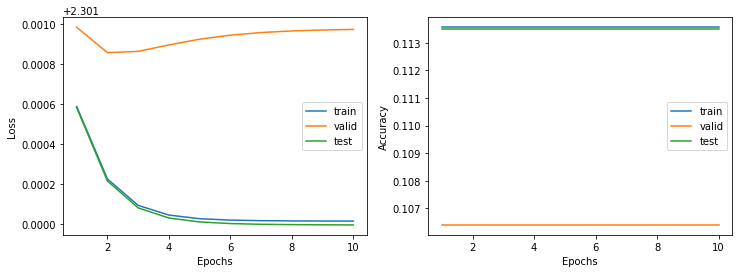

In [9]:
mlp = NN(hidden_dims = (512, 512), weight_initer = ZeroInitializer(), input_size = 784, output_size = 10)

train_accuracies, train_losses = [], []
valid_accuracies, valid_losses = [], []
test_accuracies, test_losses = [], []
num_epochs = 10

for e in range(num_epochs):
    loss = mlp.train(X_train, y_train_onehot, mb_size=100)
    loss_train, pred_train = mlp.test(X_train, y_train_onehot)
    loss_valid, pred_valid = mlp.test(X_valid, y_valid_onehot)
    loss_test, pred_test = mlp.test(X_test, y_test_onehot)
    
    valid_losses.append(loss_valid)
    test_losses.append(loss_test)
    valid_accuracies.append((pred_valid == y_valid).mean())
    test_accuracies.append((pred_test == y_test).mean())
    train_losses.append(loss_train)
    train_accuracies.append((pred_train == y_train).mean())

## Loss figure
plt.figure(figsize=(12, 4))
axis = plt.subplot(1, 2, 1)
axis.plot(range(1, len(train_losses)+1), train_losses, label='train')
axis.plot(range(1, len(valid_losses)+1), valid_losses, label='valid')
axis.plot(range(1, len(test_losses)+1), test_losses, label='test')
axis.legend()
axis.set_ylabel('Loss')
axis.set_xlabel('Epochs')

## Accuracy figure
axis = plt.subplot(1, 2, 2)
axis.plot(range(1, len(train_accuracies)+1), train_accuracies, label='train')
axis.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='valid')
axis.plot(range(1, len(test_accuracies)+1), test_accuracies, label='test')
axis.legend()
axis.set_ylabel('Accuracy')
axis.set_xlabel('Epochs')

In [44]:
arr = np.asarray([1,2,3])
print(arr.shape)
print(len(arr.shape))

(3,)
1
